In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom
from scipy.interpolate import interp2d
from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
from Map import ly_noise,heii_noise,civ_noise,lyemissioncube,\
heiiemissioncube,civemissioncube,heiivelocitymap,civvelocitymap,\
heiispec,civspec

In [88]:
def interpolate_grid(x,y,img,xnew,ynew,method='linear'):
    
    interfunc=interp2d(y,x,img,kind=method)
    img_inter=interfunc(ynew,xnew)
    return img_inter

def radiu_profile(x,y):
    
    x_mesh,y_mesh=np.meshgrid(y,x)
    r_mesh=np.sqrt((x_mesh**2)+(y_mesh**2))
    return r_mesh


def velocity_sigma(img_nb,flux_noise,velo,velo_axis):
    
    velo_cube=np.ones((velo_axis.size,velo.shape[0],velo.shape[1]))
    for i in range(velo_axis.size):
        velo_cube[i,:,:]=velo_axis[i]*velo_cube[i,:,:]
    
    v_sigma=(flux_noise/img_nb)*np.sqrt(((velo_cube-velo)**2).sum(axis=0))
    
    return v_sigma

def img_bin(img1,img2,snr1,snr2,snr3,sigma1,sigma2,r_mesh,
            nx,ny,delta_x=5,delta_y=5,thre=3.5,thre2=3.):
    
    snr_r=snr1.copy()
    lib1,lib2,r_lib,lib_sigma1,lib_sigma2=[],[],[],[],[]
    for i in range(nx,img1.shape[0]-nx,nx+delta_x):
        for j in range(ny,img1.shape[1]-ny,ny+delta_y):
            cell01=img1[i-nx:i+nx,j-ny:j+ny]
            cell02=img2[i-nx:i+nx,j-ny:j+ny]
            cellsnr1=snr1[i-nx:i+nx,j-ny:j+ny]
            cellsnr2=snr2[i-nx:i+nx,j-ny:j+ny]
            cellsnr3=snr3[i-nx:i+nx,j-ny:j+ny]
            jud1=(cellsnr1>thre)
            jud2=(cellsnr2>thre)
            jud3= (cellsnr3>thre2)
            cell11=cell01[jud1&jud3]
            cell12=cell02[jud2&jud3]
            
            scell01=sigma1[i-nx:i+nx,j-ny:j+ny]
            scell02=sigma2[i-nx:i+nx,j-ny:j+ny]
            scell11=scell01[jud1&jud3]
            scell12=scell02[jud2&jud3]
            if (cell11.size>0)&(cell12.size>0):
                lib1.append(cell11.mean())
                lib2.append(cell12.mean())
                lib_sigma1.append(np.median(scell11)/np.sqrt(scell11.size))
                lib_sigma2.append(np.median(scell12)/np.sqrt(scell12.size))
                r=r_mesh[i-nx:i+nx,j-ny:j+ny]
                r_lib.append(r.min())
                snr_r[i-nx:i+nx,j-ny:j+ny]=0.
    
    return np.array(lib1),np.array(lib2),np.array(r_lib) \
,np.array(lib_sigma1),np.array(lib_sigma2)

In [181]:
ly_nb=lyemissioncube.optimal_img*1e-17
heii_nb=heiiemissioncube.optimal_img*1e-17
civ_nb=civemissioncube.optimal_img*1e-17
heiivelo=heiivelocitymap.copy()
civvelo=civvelocitymap.copy()

heii_judge=np.ones_like(heii_nb).astype(np.bool)
heii_judge[25:44,9:]=False
civ_judge=np.ones_like(civ_nb).astype(np.bool)
civ_judge[23:46,8:]=False

ly_noise1=ly_noise*1e-17*np.sqrt(lyemissioncube.shape[0])
heii_noise1=heii_noise*1e-17*np.sqrt(heiiemissioncube.shape[0])
civ_noise1=civ_noise*1e-17*np.sqrt(civemissioncube.shape[0])

lysnr=ly_nb/ly_noise1
heiisnr=heii_nb/heii_noise1
civsnr=civ_nb/civ_noise1

heii_v_sigma=velocity_sigma(heiiemissioncube.optimal_img,
                            heii_noise,heiivelocitymap,
                            heiispec)
civ_v_sigma=velocity_sigma(civemissioncube.optimal_img,
                           civ_noise,civvelocitymap,
                           civspec)

ly_nb[lysnr<=3]=3*ly_noise1
heii_nb[(heiisnr<=3)|(heii_judge)]=3*heii_noise1
civ_nb[(civsnr<=3)|(civ_judge)]=3*civ_noise1
heiivelo[(heiisnr<=3)|(heii_judge)]=0
civvelo[(civsnr<=3)|(civ_judge)]=0
heii_v_sigma[(heiisnr<=3)|(heii_judge)]=0
civ_v_sigma[(civsnr<=3)|(civ_judge)]=0


kcwi_ra=heiiemissioncube.ra.to(u.arcsec).value
kcwi_dec=heiiemissioncube.dec.to(u.arcsec).value

In [182]:
dic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/'
h_alpha=np.genfromtxt(dic+'H-alpha_intensity.txt')
h_alpha_ra=np.genfromtxt(dic+'H-alpha_ra.txt')-.8
h_alpha_dec=np.genfromtxt(dic+'H-alpha_dec.txt')-4
h_alpha_noise=1.1877882e-18
h_alpha[h_alpha<=0]=3*h_alpha_noise
h_alpha_snr=h_alpha/h_alpha_noise

In [183]:
ra_inter=np.linspace(kcwi_ra.min(),kcwi_ra.max(),400)
dec_inter=np.linspace(kcwi_dec.min(),kcwi_dec.max(),400)

ly_img=interpolate_grid(kcwi_ra,kcwi_dec,ly_nb,ra_inter,dec_inter)
heii_img=interpolate_grid(kcwi_ra,kcwi_dec,heii_nb,ra_inter,dec_inter)
civ_img=interpolate_grid(kcwi_ra,kcwi_dec,civ_nb,ra_inter,dec_inter)
h_alpha_img=interpolate_grid(h_alpha_dec,h_alpha_ra,h_alpha,ra_inter,dec_inter)


lysnr=interpolate_grid(kcwi_ra,kcwi_dec,lysnr,ra_inter,dec_inter)
civsnr=interpolate_grid(kcwi_ra,kcwi_dec,civsnr,ra_inter,dec_inter)
heiisnr=interpolate_grid(kcwi_ra,kcwi_dec,heiisnr,ra_inter,dec_inter)
h_alpha_snr=interpolate_grid(h_alpha_dec,h_alpha_ra,h_alpha_snr,ra_inter,dec_inter)

heiivelo=interpolate_grid(kcwi_ra,kcwi_dec,heiivelo,ra_inter,dec_inter)
civvelo=interpolate_grid(kcwi_ra,kcwi_dec,civvelo,ra_inter,dec_inter)

heiivsigma=interpolate_grid(kcwi_ra,kcwi_dec,heii_v_sigma,ra_inter,dec_inter)
civvsigma=interpolate_grid(kcwi_ra,kcwi_dec,civ_v_sigma,ra_inter,dec_inter)

In [184]:
ly_img=np.rot90(ly_img)[:,::-1]
heii_img=np.rot90(heii_img)[:,::-1]
civ_img=np.rot90(civ_img)[:,::-1]
h_alpha_img=h_alpha_img[:,::-1]

heiivelo=np.rot90(heiivelo)[:,::-1]
civvelo=np.rot90(civvelo)[:,::-1]
heiivsigma=np.rot90(heiivsigma)[:,::-1]
civvsigma=np.rot90(civvsigma)[:,::-1]

lysnr=ly_img/ly_noise1
heiisnr=heii_img/heii_noise1
civsnr=civ_img/civ_noise1
h_alpha_snr=h_alpha_img/h_alpha_noise

In [185]:
heii_ly=heii_img/ly_img
civ_ly=civ_img/ly_img

sigma_heii_ly=heii_ly*np.sqrt((1/heiisnr**2)+(1/lysnr**2))
sigma_civ_ly=civ_ly*np.sqrt((1/civsnr**2)+(1/lysnr**2))

heii_h_img=heii_img/h_alpha_img
civ_h_img=civ_img/h_alpha_img

sigma_heii_h=heii_h_img*np.sqrt((1/heiisnr**2)+(1/h_alpha_snr**2))
sigma_civ_h=civ_h_img*np.sqrt((1/civsnr**2)+(1/h_alpha_snr**2))

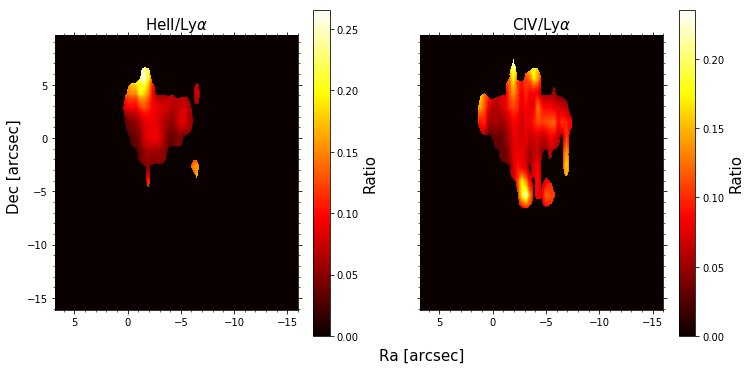

In [186]:
fig,ax=plt.subplots(1,2,sharey=True)
heii_ly[heiisnr<3.5]=0.
img=ax[0].pcolormesh(ra_inter,dec_inter,heii_ly[::-1,::-1],cmap='hot')
cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel('Ratio',fontsize=15.)
civ_ly[civsnr<3.5]=0.
img=ax[1].pcolormesh(ra_inter,dec_inter,civ_ly[::-1,::-1],cmap='hot')
cbar=plt.colorbar(img,ax=ax[1])
cbar.ax.set_ylabel(r'Ratio',fontsize=15.)

ax[0].invert_xaxis()
ax[1].invert_xaxis()
ax[0].set_aspect('equal')
ax[0].tick_params(axis='both', which='both',top=True,right=True)
ax[0].minorticks_on()
ax[1].set_aspect('equal')
ax[1].tick_params(axis='both', which='both',top=True,right=True)
ax[1].minorticks_on()
ax[0].set_title(r'HeII/Ly$\alpha$',fontsize=15.)
ax[1].set_title(r'CIV/Ly$\alpha$',fontsize=15.)

fig.text(0.07,0.6,'Dec [arcsec]',rotation='vertical',fontsize=15)
fig.text(0.5,0.07,r'Ra [arcsec]',fontsize=15)
plt.rcParams['figure.figsize'] = [12, 6]
# plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
plt.savefig(savdic+'metal_ly_ratio2D.png',dpi=300)

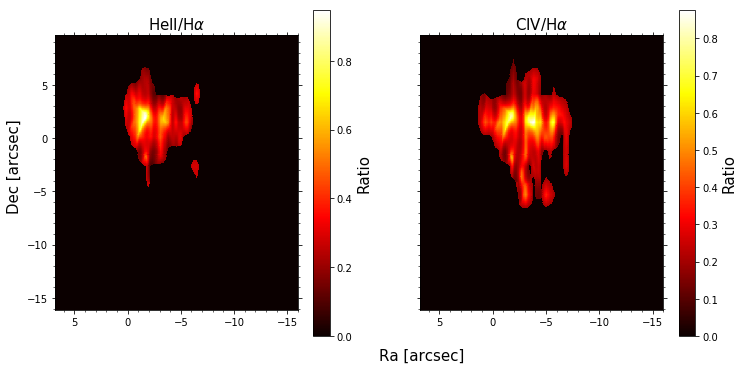

In [187]:
fig,ax=plt.subplots(1,2,sharey=True)
heii_h_img[heiisnr<3.5]=0.
img=ax[0].pcolormesh(ra_inter,dec_inter,heii_h_img[::-1,::-1],cmap='hot')
cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel('Ratio',fontsize=15.)
civ_h_img[civsnr<3.5]=0.
img=ax[1].pcolormesh(ra_inter,dec_inter,civ_h_img[::-1,::-1],cmap='hot')
cbar=plt.colorbar(img,ax=ax[1])
cbar.ax.set_ylabel(r'Ratio',fontsize=15.)

ax[0].invert_xaxis()
ax[1].invert_xaxis()
ax[0].set_aspect('equal')
ax[0].tick_params(axis='both', which='both',top=True,right=True)
ax[0].minorticks_on()
ax[1].set_aspect('equal')
ax[1].tick_params(axis='both', which='both',top=True,right=True)
ax[1].minorticks_on()
ax[0].set_title(r'HeII/H$\alpha$',fontsize=15.)
ax[1].set_title(r'CIV/H$\alpha$',fontsize=15.)

fig.text(0.07,0.6,'Dec [arcsec]',rotation='vertical',fontsize=15)
fig.text(0.5,0.07,r'Ra [arcsec]',fontsize=15)
plt.rcParams['figure.figsize'] = [12, 6]
# plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
plt.savefig(savdic+'metal_h_ratio2D.png',dpi=300)

In [188]:
r_mesh=radiu_profile(ra_inter,dec_inter)
h_l,c_l,r_l,h_l_s,c_l_s=img_bin(heii_ly,civ_ly,heiisnr,civsnr,lysnr,
                                sigma_heii_ly,sigma_civ_ly,r_mesh,10,10,13,13,thre=3.5,thre2=5.)
r_l=r_l*8.2

In [189]:
h_h,c_h,r_h,h_h_s,c_h_s=img_bin(heii_h_img,civ_h_img,heiisnr,civsnr,h_alpha_snr,
                                sigma_heii_h,sigma_civ_h,r_mesh,10,10,13,13,thre=3.5,thre2=3.)
r_h=r_h*8.2

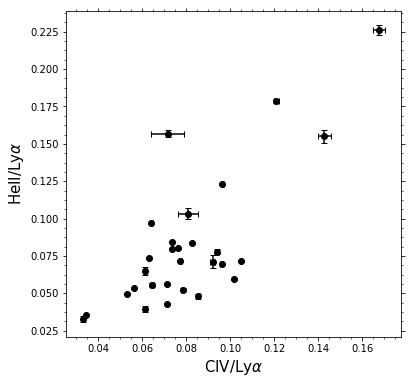

In [192]:
fig,ax=plt.subplots(1,1)
ax.errorbar(c_l,h_l,xerr=c_l_s,yerr=h_l_s,fmt='o',capsize=3.,color='black')
ax.set_ylabel(r'HeII/Ly$\alpha$',fontsize=15.)
ax.set_xlabel(r'CIV/Ly$\alpha$',fontsize=15.)
ax.tick_params(axis='both', which='both',top=True,right=True)
ax.minorticks_on()
plt.rcParams['figure.figsize'] = [6, 6]
# plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
plt.savefig(savdic+'metal_ly_ratio.png',dpi=300)

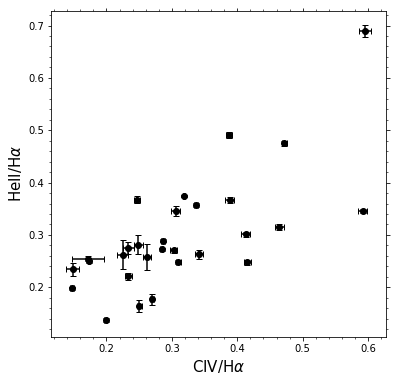

In [193]:
fig,ax=plt.subplots(1,1)
ax.errorbar(c_h,h_h,xerr=c_h_s,yerr=h_h_s,fmt='o',capsize=3.,color='black')
ax.set_ylabel(r'HeII/H$\alpha$',fontsize=15.)
ax.set_xlabel(r'CIV/H$\alpha$',fontsize=15.)
ax.tick_params(axis='both', which='both',top=True,right=True)
ax.minorticks_on()
plt.rcParams['figure.figsize'] = [6, 6]
# plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
plt.savefig(savdic+'metal_h_ratio.png',dpi=300)

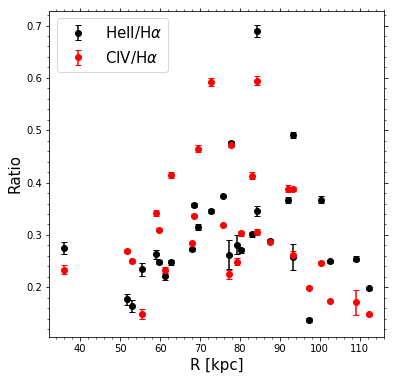

In [194]:
fig,ax=plt.subplots(1,1)
ax.errorbar(r_h,h_h,yerr=h_h_s,fmt='o',capsize=3.,color='black',label=r'HeII/H$\alpha$')
ax.errorbar(r_h,c_h,yerr=c_h_s,fmt='o',capsize=3.,color='red',label=r'CIV/H$\alpha$')
ax.set_ylabel(r'Ratio',fontsize=15.)
ax.set_xlabel(r'R [kpc]',fontsize=15.)
ax.tick_params(axis='both', which='both',top=True,right=True)
ax.minorticks_on()
plt.legend(fontsize=15.)
plt.rcParams['figure.figsize'] = [6, 5]
# plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
plt.savefig(savdic+'metal_h_profile.png',dpi=300)

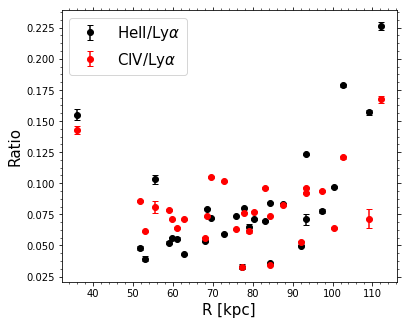

In [195]:
fig,ax=plt.subplots(1,1)
ax.errorbar(r_l,h_l,yerr=h_l_s,fmt='o',capsize=3.,color='black',label=r'HeII/Ly$\alpha$')
ax.errorbar(r_l,c_l,yerr=c_l_s,fmt='o',capsize=3.,color='red',label=r'CIV/Ly$\alpha$')
ax.set_ylabel(r'Ratio',fontsize=15.)
ax.set_xlabel(r'R [kpc]',fontsize=15.)
ax.tick_params(axis='both', which='both',top=True,right=True)
ax.minorticks_on()
plt.legend(fontsize=15.)
plt.rcParams['figure.figsize'] = [6, 5]
# plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
plt.savefig(savdic+'metal_ly_profile.png',dpi=300)